Simulated Patient 

In [1]:
import pandas as pd
import numpy as np
import os

from textwrap import wrap
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from sklearn.ensemble import RandomForestClassifier
from environment.fogg_behavioural_model import Patient 

In [2]:
updated_every_day = 24 
week= 7 * updated_every_day

In [3]:
eight_weeks = week * 8
five_weeks = week * 5

In [4]:
#basic stable condition
condition = 'stable'
habituation=False
time_preference_update_step= 9999999999999999 #very high e.g. 9999999999 to make it outside of the intervention time...effectively no preference shift

#Other options:
# condition = 'habituated'
# habituation=True
# time_preference_update_step= 9999999999999999 

# condition = 'changed_preference'
# habituation=False
# time_preference_update_step= five_weeks

# condition = 'habituated_changed_preference'
# habituation=True
# time_preference_update_step= five_weeks

In [5]:
runs = 100

In [6]:
results_directory = 'results3'
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# No interverntion

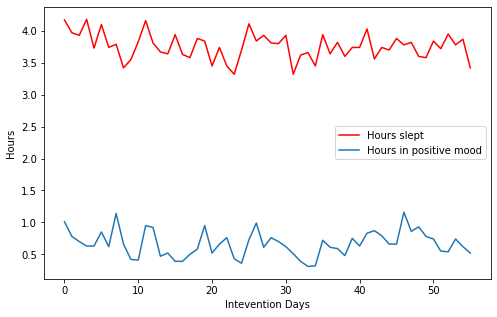

In [7]:
sleep_list = []
positive_list = []

for run in range(0, runs):
    
    env1 = Patient(habituation=habituation, time_preference_update_step=time_preference_update_step )
    action = 0
    for i in  range(eight_weeks):
        
        observation , reward, done, info = env1.step(action)
        action = 0
        
    sleep_list.append(env1.h_slept)
    positive_list.append(env1.h_positive)

fig = plt.figure( figsize=(8, 5))
plt.plot(np.nanmean(sleep_list, axis=0), label='Hours slept', color ='r')
plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
plt.ylabel('Hours ')
plt.xlabel('Intevention Days')
plt.legend()
plt.show()

# Intervention

In [8]:
def intervention(method, runs, name, condition):
    rr_random_list = []
    not_random_list = []
    sleep_list = []
    positive_list = []
    for run in range(0, runs):

        env1 = Patient(habituation=habituation, time_preference_update_step=time_preference_update_step)
        env1 = method(env1)

        df = pd.DataFrame()
        df['responce_ratio'] = env1.rr
        df['activity performed'] = env1.num_performed
        df['notifications'] = env1.num_notified
        df['sleep'] = env1.h_slept
        df['positive'] = env1.h_positive
        df['non_stationary'] = env1.h_nonstationary
        
        df.to_csv("{0}/patient1_{1}_{2}_run{3}.csv".format(results_directory, condition, name, run))
        rr_random_list.append(df.responce_ratio)
        not_random_list.append(df.notifications)
        sleep_list.append(df.sleep)
        positive_list.append(df.positive)

    
    print("This figures include failed runs (runs in which no prompt resulted in the activity being performed)")
    fig = plt.figure( figsize=(8, 5))
    plt.plot(np.nanmean(np.array(sleep_list), axis=0), label='Hours slept', color ='r')
    plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
    plt.ylabel('Hours ')
    plt.xlabel('Intevention Days')
    plt.legend()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
    ax1.plot(np.nanmean(rr_random_list, axis=0), label='responce rate', color ='r')
    ax2.plot(np.nanmean(not_random_list, axis=0), label='num notified')
    ax2.set_xlabel('Intervention Days')
    ax2.set_ylabel('No. notifications')
    ax1.set_ylabel('Responce ratio')
    plt.show()
    return sleep_list, positive_list, rr_random_list, not_random_list

## Heuristic

Notify every hour except in night and when the patinets is alseep

In [9]:
def always_notify(env1, intervention_legth=eight_weeks):
    
    action = 1
    for i in  range(intervention_legth):
        
        observation, reward, done, info = env1.step(action)
        if observation[9] == 3 :
            action = 0
        else:
            action = 1
            
    return env1

This figures include failed runs (runs in which no prompt resulted in the activity being performed)


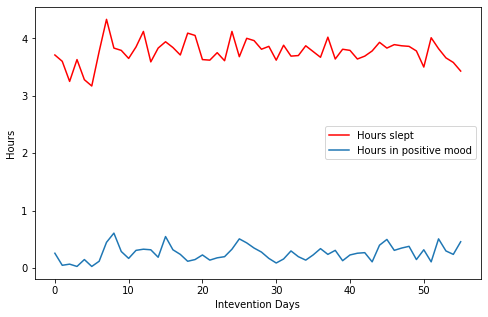

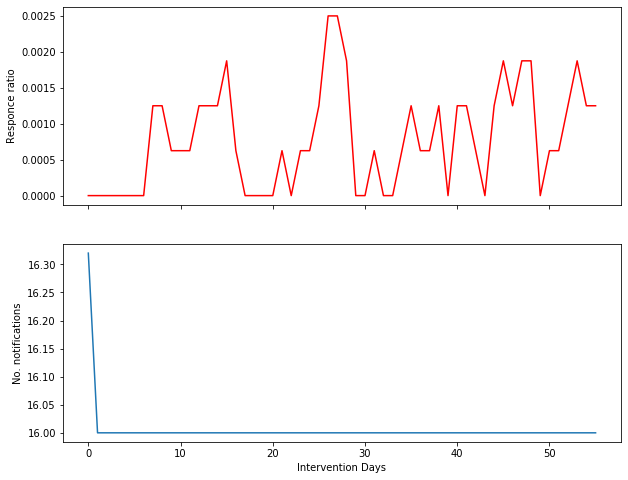

In [10]:
sleep_listh, positive_listh, rr_h_list, not_h_list = intervention(always_notify, runs, 'h', condition)

## Random 
Randomly sample during the day skip the nights

In [11]:
def random_notification(env1, intervention_legth=eight_weeks):
    
    action = 1
    for i in  range(intervention_legth):
        
        observation, reward, done, info = env1.step(action)
        if observation[9] ==3:
            action = 0
        else:
            action = env1.action_space.sample()
            
    return env1

This figures include failed runs (runs in which no prompt resulted in the activity being performed)


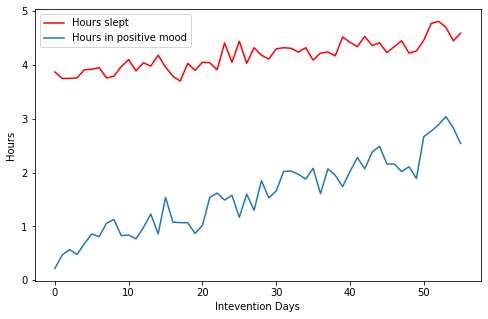

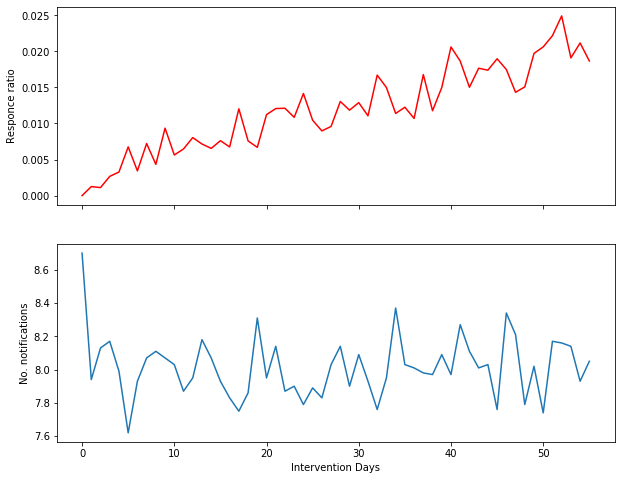

In [12]:
_ = intervention(random_notification, runs, 'random', condition)

## Supervised Learning

### static model

In [13]:
def supervised_after_three_weeks(env1):
    
    three_weeks = 24 * 7 *3
#     env1 = always_notify(env1, intervention_legth=three_weeks)
    env1 = random_notification(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - three_weeks
    observation = env1._get_current_state()
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        observation, reward, done, info = env1.step(action)
        
        
    return env1

This figures include failed runs (runs in which no prompt resulted in the activity being performed)


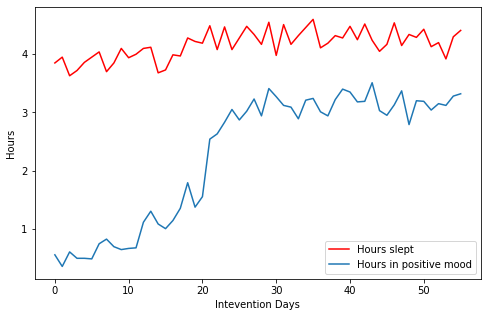

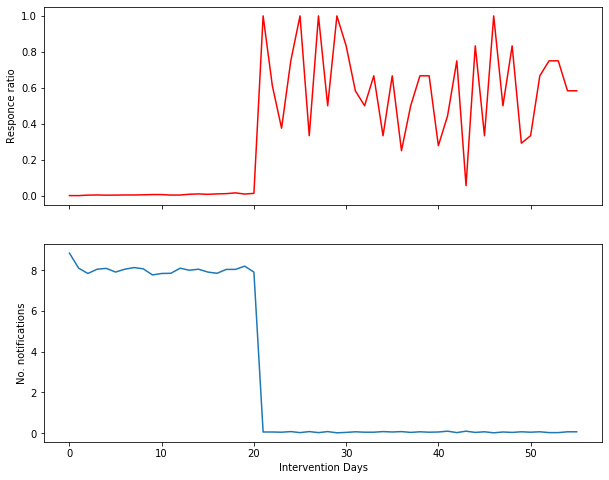

In [14]:
_ =intervention(supervised_after_three_weeks, runs, 'r_static_sup3', condition)

### adaptive model 

In [15]:
def supervised_adaptive_after_three_weeks(env1):
    
    three_weeks = 24 * 7 *3
    env1 = random_notification(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - three_weeks
    observation = env1._get_current_state()
    samples = len(env1.observation_list)
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        observation, reward, done, info = env1.step(action)
        if len(env1.observation_list)> samples: # retrain when new samples are provided
            clf = RandomForestClassifier(class_weight='balanced')
            clf.fit(env1.observation_list, env1.activity_performed)
            samples = len(env1.observation_list)
            
        
    return env1

This figures include failed runs (runs in which no prompt resulted in the activity being performed)


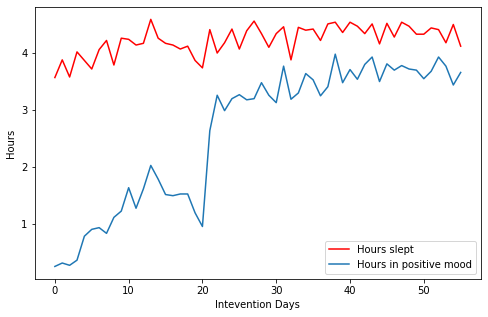

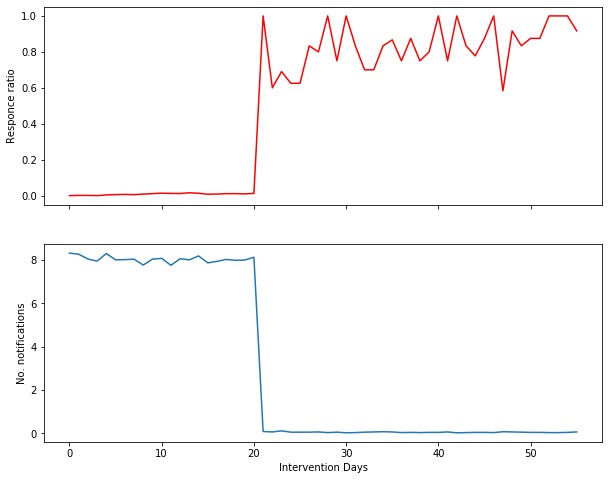

In [16]:
_ = intervention(supervised_adaptive_after_three_weeks, runs, 'r_adaptive_sup3', condition)

### How many times supervised training faild?

In [17]:
def get_rr_and_notification(name, runs, condition):
    
    rr, noti = [],[]
    failed = 0
    for run in range(runs):
        df = pd.read_csv("{0}/patient1_{1}_{2}_run{3}.csv".format(results_directory,condition, name, run))
        a_performed = sum(df['activity performed'].values)
        if a_performed > 0: # activity performed at least once in the course of the intervention
            rr.append(df.responce_ratio)
            noti.append(df.notifications)
        else:
            failed = failed +1 
    print("Training failed {0} out of {1} runs.".format(failed, runs))
    return rr, noti

In [18]:
rr_rf3_list, not_rf3_list = get_rr_and_notification('r_static_sup3', runs, condition)

Training failed 87 out of 100 runs.


In [19]:
rr_rf3a_list, not_rf3a_list = get_rr_and_notification('r_adaptive_sup3', runs, condition)

Training failed 83 out of 100 runs.


## Deep Q Network

In [20]:
def dqn(env1):
    model = DQN("MlpPolicy", env1, verbose=0, learning_starts=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

In [ ]:
_= intervention(dqn, runs, 'dqn', condition)

In [ ]:
rr_dqn_list, not_dqn_list = get_rr_and_notification('dqn', runs, condition)

## Proximal Policy Optimisation

In [ ]:
def ppo(env1):
    model = PPO("MlpPolicy", env1, verbose=0, n_steps=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

In [ ]:
_ = intervention(ppo, runs, 'ppo', condition)

In [ ]:
rr_ppo_list, not_ppo_list = get_rr_and_notification('ppo', runs, condition)

## Advantage Actor Critic

In [ ]:
def a2c(env1):
    model = A2C("MlpPolicy", env1, verbose=0, n_steps=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

In [ ]:
_ = intervention(a2c, runs, 'a2c', condition)

In [ ]:
rr_a2c_list, not_a2c_list = get_rr_and_notification('a2c', runs, condition)

In [ ]:
rr_random_list, not_random_list = get_rr_and_notification('random', runs, condition)

In [ ]:
np.nanmean(rr_rf3a_list, axis=0)

In [ ]:
rr_rf3a_list

## Comparison between prompt learning stategies

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10,10))
ax1.plot(np.nanmean(rr_random_list, axis=0), label='Random')
ax1.plot(np.nanmean(rr_rf3_list, axis=0), label='RF static')
ax1.plot(np.nanmean(rr_rf3a_list, axis=0), label='RF adaptive')
ax1.plot(np.nanmean(rr_dqn_list, axis=0), label='DQN')
ax1.plot(np.nanmean(rr_ppo_list, axis=0), label='PPO')
ax1.plot(np.nanmean(rr_a2c_list, axis=0), label='A2C')

ax2.plot(np.nanmean(not_random_list, axis=0), label='Random')
ax2.plot(np.nanmean(not_rf3_list, axis=0), label='RF static')
ax2.plot(np.nanmean(not_rf3a_list, axis=0), label='RF adaptive')
ax2.plot(np.nanmean(not_dqn_list, axis=0), label='DQN')
ax2.plot(np.mean(not_ppo_list, axis=0), label='PPO')
ax2.plot(np.mean(not_a2c_list, axis=0), label='A2C')
ax2.plot(np.ones(len(np.mean(not_random_list, axis=0))) +2, label ='Prefered number of notifications a day')

ax2.set_xlabel('Intervention Days')
ax2.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)))
ax1.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)) )
# ax3.set_ylabel( '\n'.join(wrap('Hours slept', 20)) )
ax2.legend()
plt.show()

# Intervention vs. No Intervention

Simulated patients who habituate to prompts and changes preference to be notified in the evening after 5 weeks of intervention

In [ ]:
sleep_list = []
positive_list = []
walking_list = []

for run in range(0, runs):
    
    env1 = Patient(habituation=habituation, time_preference_update_step=time_preference_update_step)
    action = 0
    for i in  range(eight_weeks):
        
        observation , reward, done, info = env1.step(action)
        action = 0
        
    sleep_list.append(env1.h_slept)
    positive_list.append(env1.h_positive)
    walking_list.append(env1.h_nonstationary)

fig = plt.figure( figsize=(8, 5))
plt.plot(np.nanmean(sleep_list, axis=0), label='Hours slept', color ='r')
plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
plt.plot(np.mean(walking_list, axis=0), label='Hours active')
plt.ylabel('Hours ')
plt.xlabel('Intevention Days')
plt.legend()
plt.show()

In [ ]:
def get_patient_state_progress(condition, name, runs):
    
    walking = []
    sleeping = []
    positive = []
    for run in range(runs):
        df = pd.read_csv('results3/patient1_{0}_{1}_run{2}.csv'.format(condition, name, run))
        a_performed = sum(df['activity performed'].values)
        if a_performed > 0:
            walking.append(df.non_stationary)
            sleeping.append(df.sleep)
            positive.append(df.positive)
    return walking, sleeping, positive
    

In [ ]:
walkingh, sleep_listh, positive_listh = get_patient_state_progress(condition, 'random', runs)

In [ ]:
walking_ppo, sleep_list_ppo, positive_list_ppo = get_patient_state_progress(condition, 'r_static_sup3', runs)

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(16, 4))
ax[0].plot(np.nanmean(sleep_list, axis=0), label='Slept', color ='r')
ax[0].plot(np.mean(positive_list, axis=0), label='In positive mood')
ax[0].plot(np.mean(walking_list, axis=0), label='Non-stationary activity')
ax[1].plot(np.nanmean(sleep_listh, axis=0), label='Hours slept', color ='r')
ax[1].plot(np.mean(positive_listh, axis=0), label='Hours in positive mood')
ax[1].plot(np.mean(walkingh, axis=0), label='Active')
ax[2].plot(np.nanmean(sleep_list_ppo, axis=0), label='Hours slept', color ='r')
ax[2].plot(np.mean(positive_list_ppo, axis=0), label='Hours in positive mood')
ax[2].plot(np.mean(walking_ppo, axis=0), label='Active')
ax[0].set_ylabel('Hours', fontsize=14)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Intevention Days', fontsize=14)
ax[1].set_xlabel('Intevention Days', fontsize=14)
ax[2].set_xlabel('Intevention Days', fontsize=14)
ax[0].set_title('No intervention', fontsize=14)
ax[1].set_title('Intervention with random prompts', fontsize=14)
ax[2].set_title("Intervention with 'timely' prompts", fontsize=14)